<a href="https://colab.research.google.com/github/SantiagoGomezfpv/hyperparameter/blob/main/Graphs_Optuna_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optuna Graphs
Este notebook de Colab está diseñado para entrenar y optimizar un modelo de red neuronal de grafos (GCN) utilizando el conjunto de datos Cora. Usaremos la biblioteca Optuna para encontrar la mejor configuración de hiperparámetros para nuestro modelo. A continuación se explica cada parte del código.



## Instalación de Librerías
Para empezar, debemos instalar algunas librerías adicionales necesarias para trabajar con PyTorch Geometric y Optuna.

La instalación se realiza siguiendo las instrucciones y codigo proporcionadas en este [enlace](https://gist.github.com/ameya98/b193856171d11d37ada46458f60e73e7?permalink_comment_id=3674777).



---


**Nota**: La instalación de las bibliotecas necesarias puede tardar unos minutos, ya que algunas de ellas son paquetes grandes que requieren tiempo para descargarse y configurarse adecuadamente. Asegúrate de tener una conexión a internet estable para evitar interrupciones en el proceso de instalación.

In [ ]:
# Primero, instalamos Optuna para la optimización de hiperparámetros
!pip install optuna

# Formateamos las versiones de PyTorch y CUDA para instalar los paquetes de PyTorch Geometric correctamente
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

# Instalamos las dependencias de PyTorch Geometric
!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 94.5 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 46.6 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 42.6 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.0 MB/s eta 0:00:00


## Importación de Bibliotecas
Luego, importamos las bibliotecas necesarias:

* `optuna` se utiliza para la optimización de hiperparámetros.
* `torch` es la biblioteca de PyTorch para construir y entrenar modelos de aprendizaje profundo.
* `torch.nn.functional` contiene funciones para construir redes neuronales.
* `GCNConv` es la capa convolucional para grafos de PyTorch Geometric.
* `Planetoid` es el conjunto de datos de PyTorch Geometric que contiene el dataset Cora.

In [ ]:
import optuna
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

## Cargar el Dataset Cora
Cargamos el conjunto de datos Cora utilizando la biblioteca PyTorch Geometric.

`Planetoid` descarga y prepara el dataset Cora, que contiene información sobre publicaciones científicas y sus relaciones.

In [ ]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


## Definición de la Red Neuronal de Grafos (GCN)
Definimos la arquitectura de nuestra red neuronal de grafos (GCN) basada en los hiperparámetros sugeridos por Optuna.

* `GCNConv` crea una capa convolucional para grafos.
* `ModuleList` agrupa las capas en una lista que puede ser iterada.
* `F.relu` aplica la función de activación ReLU.
* `F.dropout` aplica la técnica de dropout para evitar el sobreajuste.
* `F.log_softmax` aplica la función de activación softmax en el resultado final.


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_units_list, output_dim):
        super(GCN, self).__init__()
        self.layers = torch.nn.ModuleList()
        in_channels = input_dim

        for hidden_units in hidden_units_list:
            self.layers.append(GCNConv(in_channels, hidden_units))
            in_channels = hidden_units

        self.layers.append(GCNConv(in_channels, output_dim))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for conv in self.layers[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)

        x = self.layers[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

## Función Objetivo para Optuna
Definimos una función objetivo para Optuna que optimizará los hiperparámetros del modelo.

* `suggest_int` sugiere un número entero para el número de capas ocultas y unidades ocultas.
* `Adam` es el optimizador utilizado para actualizar los pesos del modelo.
* `nll_loss` calcula la pérdida de entropía cruzada negativa.
* `train_mask` y `test_mask` se utilizan para separar los datos de entrenamiento y prueba.

Optuna está optimizando los siguientes hiperparámetros de la red neuronal:

* `hidden_layers:` Define cuántas capas ocultas tendrá la red neuronal. Optuna prueba diferentes cantidades de capas ocultas dentro del rango especificado (1 a 5).

* `hidden_units_list:` Para cada capa oculta, define cuántas unidades (neurona) tendrá esa capa. Optuna prueba diferentes cantidades de unidades en cada capa dentro del rango especificado (16 a 256).


In [ ]:
def objective(trial):
    hidden_layers = trial.suggest_int('hidden_layers', 1, 5)
    hidden_units_list = [trial.suggest_int(f'hidden_units_{i}', 16, 256) for i in range(hidden_layers)]

    model = GCN(dataset.num_node_features, hidden_units_list, dataset.num_classes).to(device)
    data = dataset[0].to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

## Ejecución de la Optimización
Finalmente, ejecutamos la optimización de hiperparámetros con Optuna.

* `optuna.create_study` crea un estudio de optimización.
* `study.optimize` ejecuta la optimización de la función objetivo durante un número definido de pruebas.
* Se imprimen los mejores hiperparámetros encontrados.


In [ ]:
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=300)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-07-11 03:23:05,317] A new study created in memory with name: no-name-d7b342c7-85de-40a1-b815-47e92762d182
[I 2024-07-11 03:23:09,026] Trial 0 finished with value: 0.786 and parameters: {'hidden_layers': 3, 'hidden_units_0': 84, 'hidden_units_1': 155, 'hidden_units_2': 147}. Best is trial 0 with value: 0.786.
[I 2024-07-11 03:23:09,906] Trial 1 finished with value: 0.782 and parameters: {'hidden_layers': 2, 'hidden_units_0': 53, 'hidden_units_1': 118}. Best is trial 0 with value: 0.786.
[I 2024-07-11 03:23:11,395] Trial 2 finished with value: 0.779 and parameters: {'hidden_layers': 5, 'hidden_units_0': 30, 'hidden_units_1': 188, 'hidden_units_2': 39, 'hidden_units_3': 79, 'hidden_units_4': 87}. Best is trial 0 with value: 0.786.
[I 2024-07-11 03:23:12,309] Trial 3 finished with value: 0.791 and parameters: {'hidden_layers': 2, 'hidden_units_0': 161, 'hidden_units_1': 208}. Best is trial 3 with value: 0.791.
[I 2024-07-11 03:23:13,657] Trial 4 finished with value: 0.75 and parame

Number of finished trials:  300
Best trial:
  Value:  0.824
  Params: 
    hidden_layers: 2
    hidden_units_0: 238
    hidden_units_1: 221


## Visualización de los Resultados
Optuna proporciona herramientas de visualización para entender mejor los resultados de la optimización.

* `plot_optimization_history`: Muestra cómo ha cambiado el valor objetivo a lo largo de los ensayos.
* `plot_parallel_coordinate`: Muestra las relaciones entre los parámetros y el valor objetivo.
* `plot_param_importances`: Muestra la importancia relativa de cada parámetro.


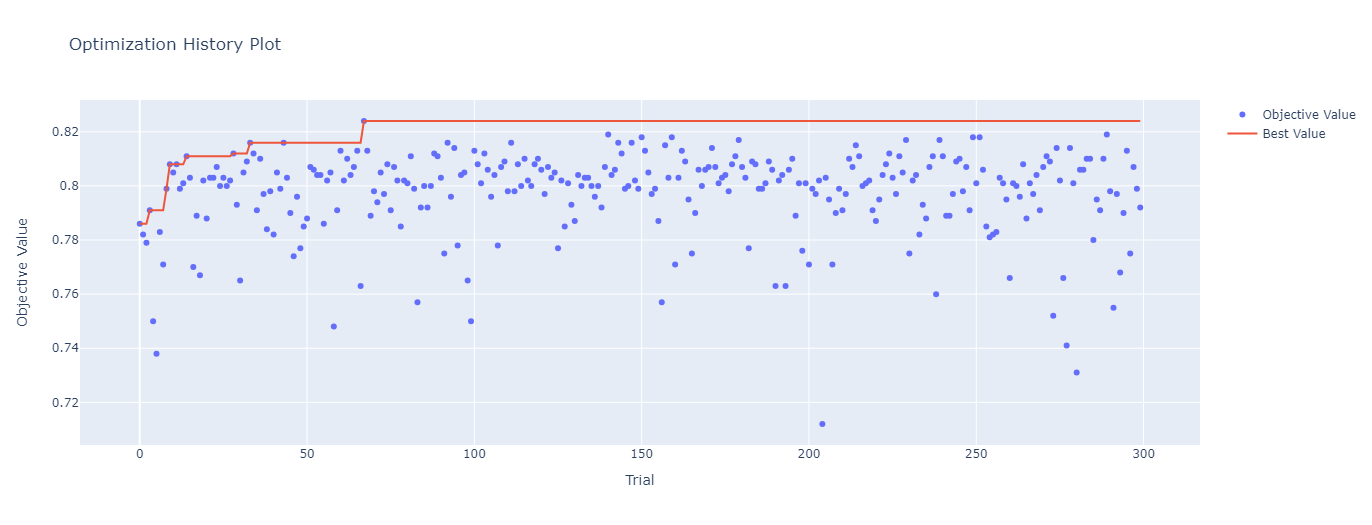

In [ ]:
import matplotlib.pyplot as plt
best_params = study.best_params

optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)